In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

#import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 5,
             'diam_ca100': 50*u.mm,
             'var_units': u.nm} # useful for PSD

fm_list = [1, 2, 3, 4, 5, 6, 7, 8]
ntot= len(fm_list)
fits_folder = 'zygo_data/flat_mirrors/fixed_fits/'

# build dust lists
fm = [] # objects list: [flat mirror with average dust masked].objects
flat_cal = np.zeros((ntot, opt_parms['ovs']*opt_parms['ovs']))
flat_var = np.zeros((ntot))

# This loop masks the dust per step for all the optics
for nf in range(0, ntot): # choose optic
    fm_num = fm_list[nf]
    
    # open the dust sets
    filename = fits_folder+'flat_2in_ca{0}_n{1}_dustmask'.format(opt_parms['ca'], fm_num)
    
    # calculate the PSD
    adp = psd.surfPSD(surf_name='fm{0}_alldust'.format(fm_num))
    adp.open_surf(fileloc=filename+'_surf.fits', surf_units=opt_parms['surf_units'])
    adp.open_mask(fileloc=filename+'_mask.fits')
    adp.calc_psd(oversamp=opt_parms['ovs'], var_unit=opt_parms['var_units'])
    #adp.write_psd_file(filename=filename+'_PSD.fits', psd_data=adp.psd_cal, single_precision=False)
    adp.calc_psd_radial(ring_width=opt_parms['ring_width'])
    print('PSD and radial profile for all dust masked in fm{0} complete.'.format(fm_num))
    
    # add objects to the lists
    fm.append(adp)
    flat_cal[nf] = adp.psd_cal.reshape(opt_parms['ovs']*opt_parms['ovs'])
    flat_var[nf] = adp.var.value

PSD and radial profile for all dust masked in fm1 complete.
PSD and radial profile for all dust masked in fm2 complete.
PSD and radial profile for all dust masked in fm3 complete.
PSD and radial profile for all dust masked in fm4 complete.
PSD and radial profile for all dust masked in fm5 complete.
PSD and radial profile for all dust masked in fm6 complete.
PSD and radial profile for all dust masked in fm7 complete.
PSD and radial profile for all dust masked in fm8 complete.
CPU times: user 4min 39s, sys: 1min 42s, total: 6min 21s
Wall time: 6min 9s


In [3]:
# calculate the average flat PSD
# using the calibrated PSD for averaging because all the flats were made the same way.
cal_psd_avg = np.mean(flat_cal, axis=0).reshape(opt_parms['ovs'], opt_parms['ovs'])*fm[0].psd_cal.unit
# calibrate the average PSD
var_avg = np.mean(flat_var)*fm[0].var.unit
#cal_psd_avg = norm_psd_avg*var_avg
#create the radial psd profile by making its own object
avg_psd = psd.surfPSD(surf_name='fm2inch_alldust_avg')
avg_psd.load_psd(psd_data=cal_psd_avg, psd_type='cal', var=var_avg)
avg_psd.load_psd_parameters(oversamp=fm[0].oversamp,
                            diam_ca=fm[0].diam_ca,
                            npix_diam=fm[0].npix_diam,
                            wavelen=fm[0].wavelen)
avg_psd.calc_rms_set(kmid_ll=0.1/u.mm, khigh_ll=1/u.mm, pwr_opt=avg_psd.psd_cal)
avg_psd.write_psd_file(filename=fits_folder+'flat_2in_ca{0}_avg_dustmask_PSD_test1.fits'.format(opt_parms['ca']),
                       psd_data = avg_psd.psd_cal,
                      single_precision=False)
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for all dust masked in averaged surface complete.')

PSD and radial profile for all dust masked in averaged surface complete.


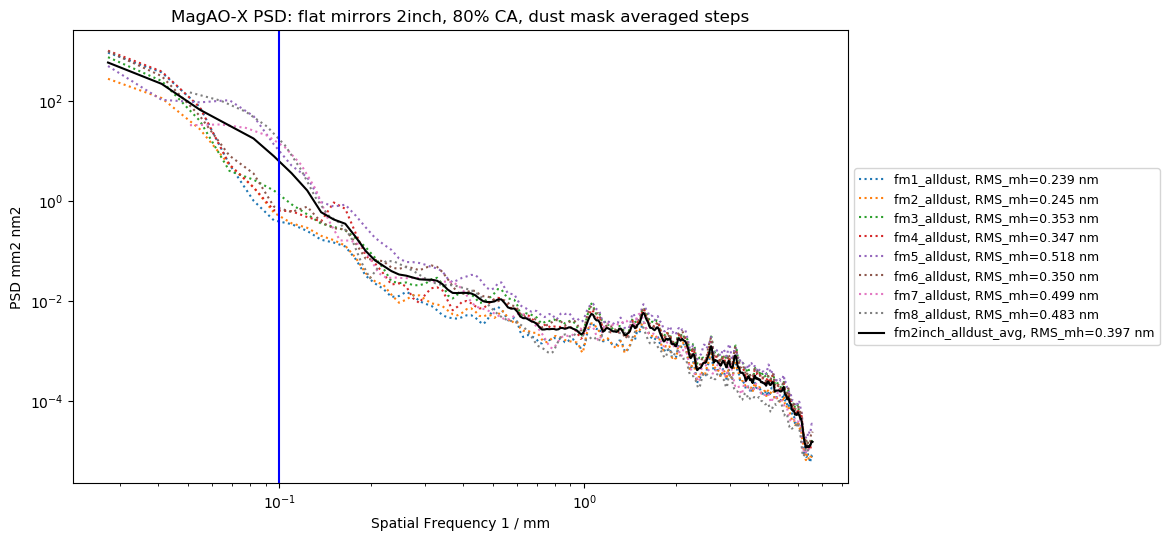

In [4]:
plt.figure(figsize=[10,6],dpi=100)
for obj in fm:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS_mh={1:.3f}'.format(obj.surf_name, obj.rms_mh))
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_mh={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_mh))
plt.xlabel('Spatial Frequency {0}'.format(fm[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(fm[0].psd_radial_cal.unit))
plt.title('MagAO-X PSD: flat mirrors 2inch, {0}% CA, dust mask averaged steps'.format(opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(x=0.1, color='b')

In [5]:
# special lines
tweeter_diam = 18.8 * u.mm
k_bmc2k = 1/tweeter_diam
nact_tweeter = 24
M1_radius = 3.25 * u.m
tweeter_BW = nact_tweeter / ((M1_radius*2).to(u.mm))

surf_rough = (1*u.nm).to(u.mm)

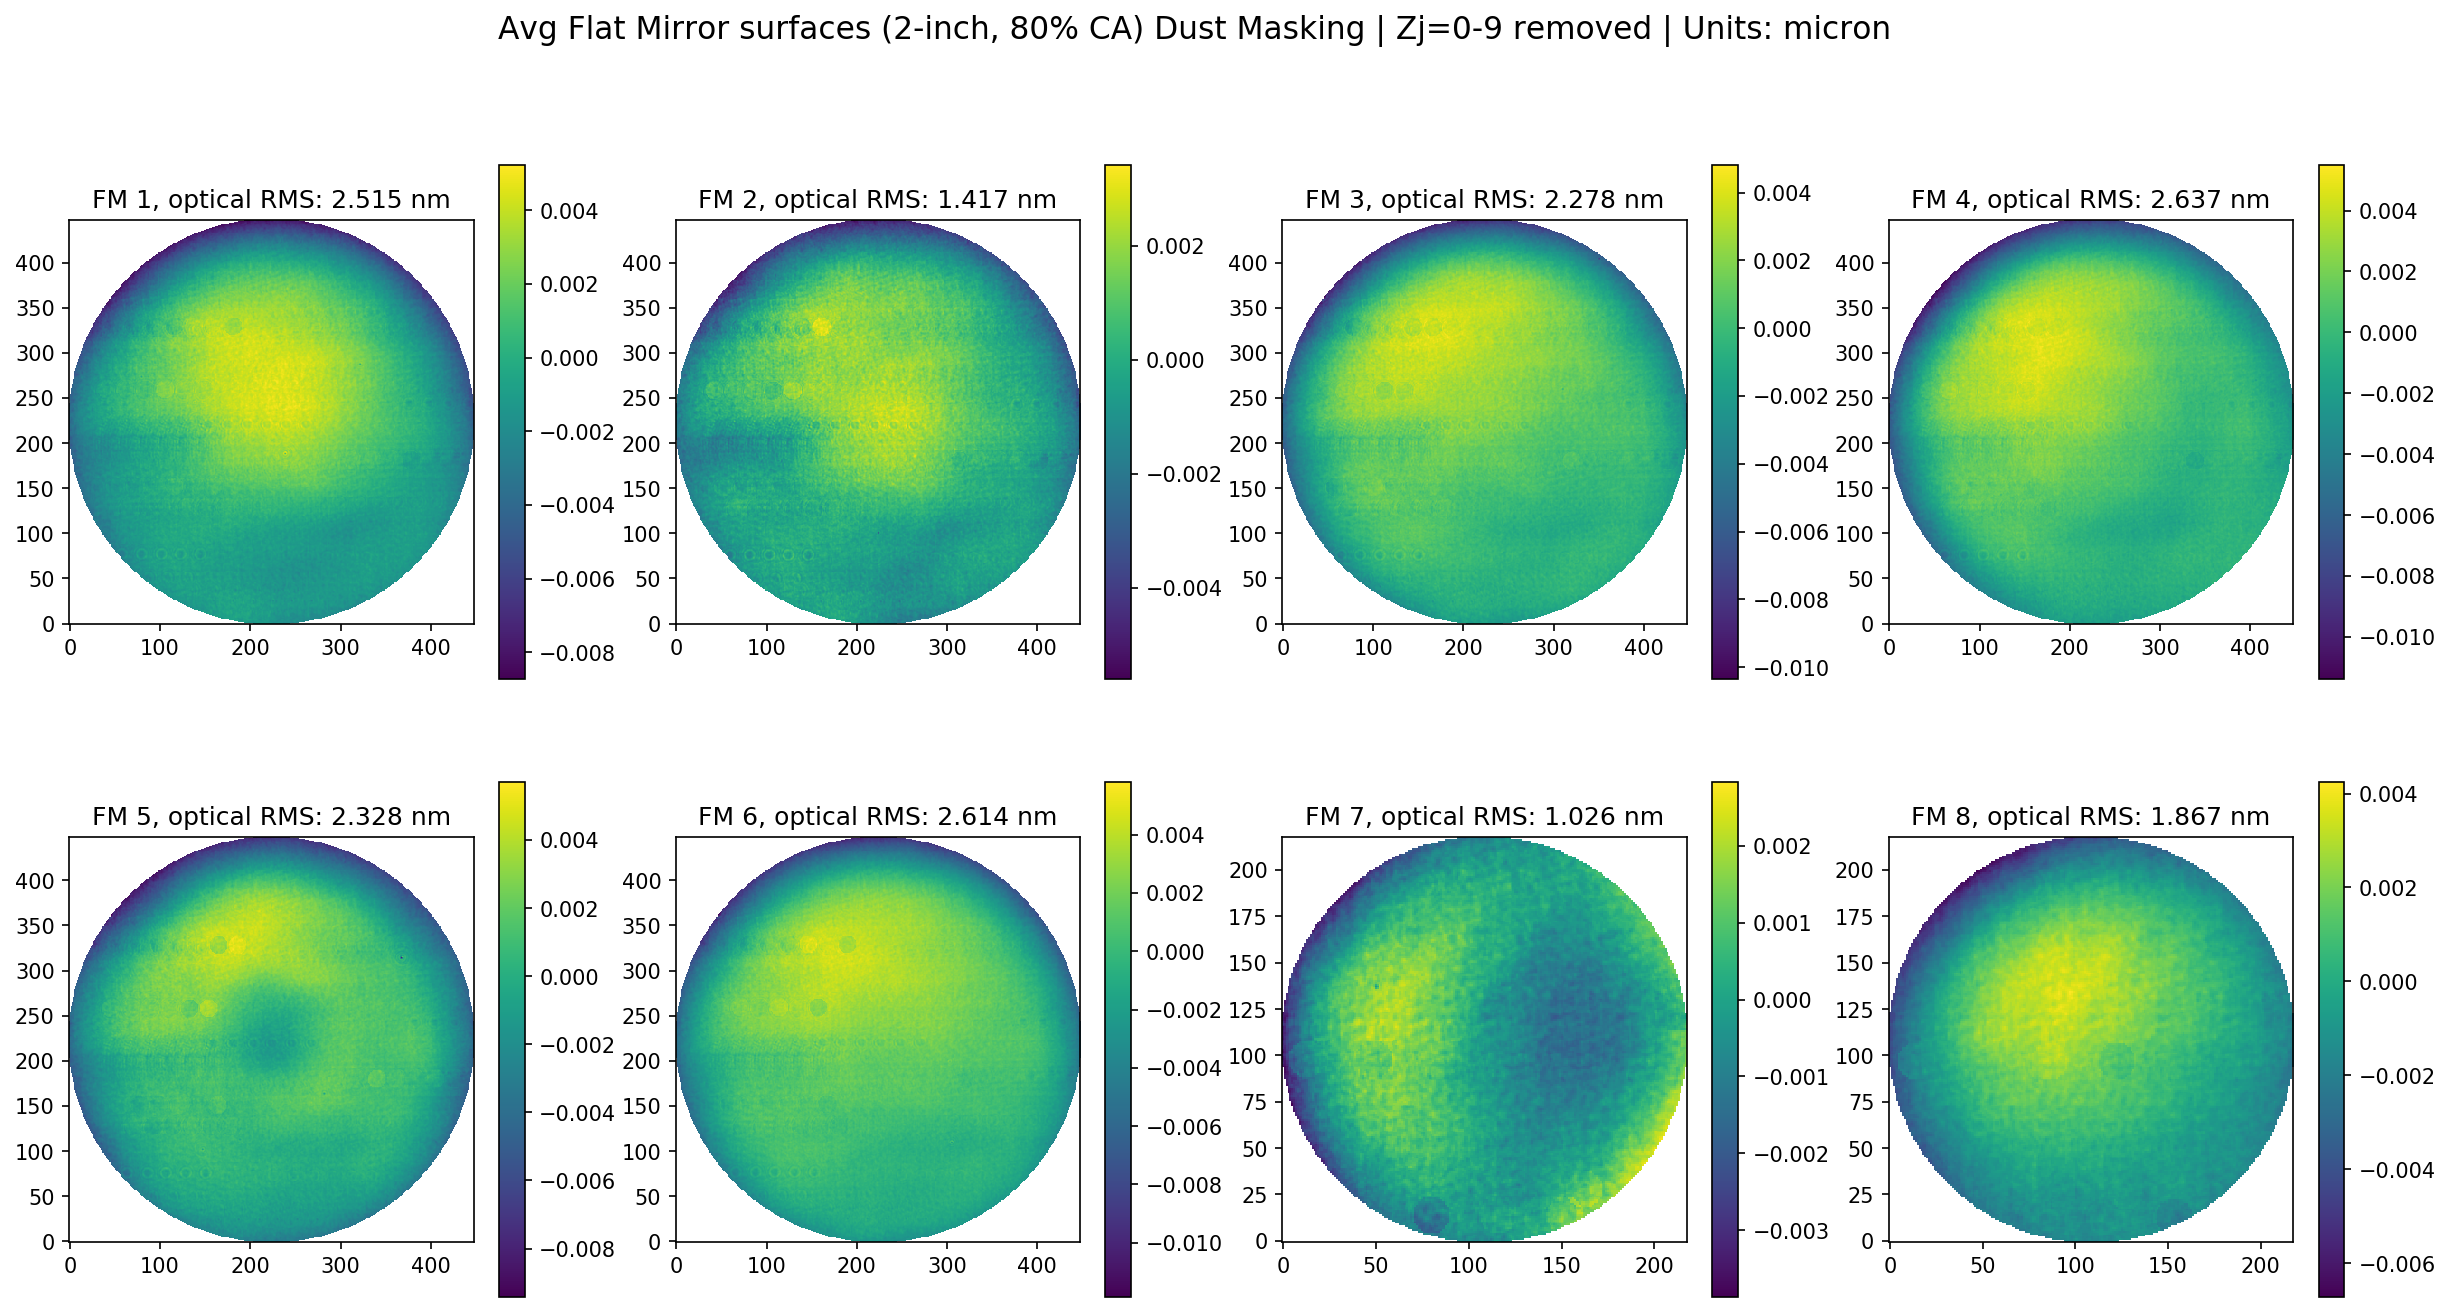

In [6]:
# plot the average surfaces
plt.figure(figsize=[20, 10], dpi=150)
plt.suptitle('Avg Flat Mirror surfaces (2-inch, {0}% CA) Dust Masking | Zj=0-9 removed | Units: {1}'.format(opt_parms['ca'], opt_parms['surf_units']), fontsize=15)
for nstep in range(0,ntot):  
    order = '24{0}'.format(nstep+1)
    plt.subplot(order)
    opt_surface = (fm[nstep].data.to(u.micron)).value
    active_mask = fm[nstep].mask
    plt.imshow(dfx.sn_map(opt_surface, active_mask), origin='lower')#, vmin=vmin, vmax=vmax)
    #plt.imshow(opt_surface.value, origin='lower')
    tot_rms = np.sqrt(fm[nstep].var)
    plt.title('FM {0}, optical RMS: {1:.3f}'.format(nstep+1, tot_rms))
    plt.colorbar()

### Calculate the RMS at low, mid, high spatial frequency bands.
Verify that manufacturer met specs.

In [7]:
# Evaluate the rms at low, mid, high spatial frequency 
klow_min = 1/(40*u.mm)
klow_max = 1/(10*u.mm)
klow_rms_target = 7.5*u.nm

kmid_min = 1/(10*u.mm)
kmid_max = 1/(1*u.mm)
kmid_rms_target = 10.2*u.nm

khigh_min = 1/(1*u.mm)
khigh_max = 1/(0.085*u.mm)
khigh_rms_target = 5.2*u.nm

print('RMS calculations: FM 80% CA 2-inch')
print('{0:>19} | {1:^9.4} | {2:^10} | {3:^9}'.format('optic', 'low', 'mid-high', 'total'))
#print('{0:>7} | {1:.4f} | {2:2.4f} | {3:.4f}'.format('tgt', klow_rms_target, kmid_rms_target, khigh_rms_target))

for obj in fm:
    print('{0:>19} | {1:.4f} | {2:7.4f} | {3:.4f}'.format(obj.surf_name, obj.rms_l, obj.rms_mh, obj.rms_tot))

# calculate the average PSD rms
print('{0:>19} | {1:.4f} | {2:7.4f} | {3:.4f}'.format(avg_psd.surf_name, avg_psd.rms_l, avg_psd.rms_mh, avg_psd.rms_tot))

RMS calculations: FM 80% CA 2-inch
              optic |    low    |  mid-high  |   total  
        fm1_alldust | 1.8839 nm |  0.2390 nm | 1.8990 nm
        fm2_alldust | 1.0645 nm |  0.2450 nm | 1.0923 nm
        fm3_alldust | 1.6088 nm |  0.3525 nm | 1.6470 nm
        fm4_alldust | 1.9409 nm |  0.3467 nm | 1.9716 nm
        fm5_alldust | 1.6768 nm |  0.5183 nm | 1.7551 nm
        fm6_alldust | 1.8238 nm |  0.3496 nm | 1.8570 nm
        fm7_alldust | 0.7940 nm |  0.4993 nm | 0.9380 nm
        fm8_alldust | 1.2599 nm |  0.4827 nm | 1.3492 nm
fm2inch_alldust_avg | 1.6176 nm |  0.3965 nm | 1.6655 nm
